In [240]:
import numpy as np

In [5]:
data = np.random.rand(10000)

In [409]:
from re import S
from collections import deque


class GK:
    def __init__(self, approximation):
        self.approximation = approximation
        self.summary = []
        # count len of summary
        self.s = 0
        # count totall n
        self.n = 0

    def insert(self, x):
        if self.n % int(1/(2*self.approximation)) == 0:
            self._compress()
        # Find the smallest i , such that v_i-1 <= v < v_i
        i = 0
        while i < self.s and self.summary[i]['val'] < x:
            i+=1
        
        # calculate delta
        delta = 0 if i == 0 or i == self.s else int(self._get_two_approx())
        
        # insert
        self.summary.insert(i, {
            'val': x,
            'g': 1,
            'delta': delta
        })
        self.s += 1
        self.n += 1

    def _get_two_approx(self):
        return 2*self.n*self.approximation
        
    
    def _merge(self, i,k,g):
        # merge two parts 
        end = self.summary[i+1:]
        begin = self.summary[:k]
        new = self.summary[i]
        new['g'] = g
        self.s -= i-k
        return begin + [new] + end


    def _compress(self):
        # approximation 
        i = int(self.s-1)
        while i > 1:
            g = self.summary[i]['g']
            k = i
            for j in reversed(range(0,i)):
                approximation = g + self.summary[j]['g'] + self.summary[i]['delta']
                if approximation > self._get_two_approx():
                    break
                g+=self.summary[j]['g']
                k = j
            self.summary = self._merge(i, k, g)
            i = k-1


    def query(self, quantile):
        en = self.approximation * self.n
        r = int(quantile * self.n)
        r_min = 0
        for s in self.summary:
            r_min += s['g']
            r_max = r_min + s['delta']
            if r - r_min <= en and r_max - r <= en:
                return s['val']
      

    def __len__(self):
        return self.s
    


class LinSW:
    def __init__(self, approximation, N):
        self.approximation = approximation
        self.buckets = []
        self.n = 0
        self.k = 0
        self.N = N
        self.bucket_size = int((self.approximation*self.N)/2) or 1
        self.curent = GK(approximation/4)

    def insert(self, x):
        if len(self.curent) == self.bucket_size:
            self.compress(self.curent)
            self.curent = GK(self.approximation/4)
        if self.n == self.N:
            self.buckets.pop()
            self.n -= self.bucket_size
        self.curent.insert(x)
        self.n+=1
        self.k+=1


    def compress(self, curent):
        first = curent.summary[0]
        first['delta'] += first['g']
        compressed = [(first['val'], first['g'], first['delta'])]
        r_min = first['g']
        for i in range(1, min(int(2/self.approximation)+1, len(self.curent.summary)-1)):
            r_min += curent.summary[i]['g']
            r_max = r_min + curent.summary[i]['delta']
            if i * int(self.approximation * self.N/2) - self.approximation*self.N/4 <= r_min <=r_max<= i * int(self.approximation * self.N/2) + self.approximation*self.N/4:
                compressed.append((curent.summary[i]['val'], r_min, r_max))

        r = 0
        for i in curent.summary:
            r+=i['g']

        compressed.append((curent.summary[-1]['val'], r, r + self.curent.summary[-1]['delta']))
        self.buckets.insert(0, compressed)
    

    def merge(self):
        S_merge = []
        r_negs = [0]
        r_pos = []
        k = 0
        r_i_0 = [0 for i in range(len(self.buckets))]
        ns = [len(bucket) for bucket in self.buckets]
        if len(self.curent.summary):
            self.compress(self.curent)
        s = self.buckets


        while s:
            small = None
            ix = 0
            it = 0
            for idx, i in enumerate(s):
                for itx, t in enumerate(i):
                    if not small or t[0] < small:
                        small = t[0]
                        ix = idx
                        it = itx
            smallest = s[ix].pop(it)
            if not len(s[ix]):
                s.pop(ix)
            k += 1
            v_k = smallest[0]

            r_negs.append(r_negs[k-1] + smallest[1] + (s[ix][it-1][1] if it !=0 else 0))
            if k == 1:
                r_k_pos = self.approximation * sum(ns[:k]) + 1
                r_pos.append(r_k_pos)
            else:
                r_k_pos = r_negs[k-1] + 2 * self.approximation * sum(ns[:k])
                r_pos.append(r_k_pos)

            S_merge.append([v_k, r_negs[-1], r_k_pos])
        return S_merge




    def lift(self, merged):
        S_lift = []
        for i in merged:
            new_i = i
            new_i[2] += int(self.approximation*self.N/2) 
            S_lift.append(new_i)
        return S_lift


    def query(self, q):
        buckets = self.merge()

        buckets = self.lift(buckets)
        en = self.approximation * self.n
        r = int(q * self.n)
        for s in buckets:
            if r - s[1] <= en and s[2] - r <= en and s[1]<s[2]:
                return s[0]
        return buckets[-1][0]




    





In [386]:
t = LinSW(0.05, 1000)
data = [i for i in range(1000)]
for i in data:
  t.insert(i)

In [387]:
t.query(0.5)

449

I could not achieve good result with Lin SW, so for my further analyses I will use GK01

In [393]:
#### Tests ####
NUM_TESTS = 10
for test in range(1,NUM_TESTS):
    data = np.random.randint(1000, size=1000*test)
    q = GK(0.0005)
    for i in data:
        q.insert(i)

    data = sorted(data)
    assert q.query(0.5) in data[int(1000*test/2) - int(0.005 * 1000*test):int(1000*test/2) + int(0.005*1000*test)]




In [414]:
import timeit
import math
sizes = [100, 1000, 10000, 100000]
aprox = [0.5, 0.05, 0.005, 0.0005]
time = []
size = []
upper_bound = []
for s in sizes:
    for a in aprox:
        data = np.random.randint(1000, size=s)
        q = GK(a)
        time_b = timeit.default_timer() 
        for i in data:
            q.insert(i)
        q.query(0.5)
        time_e = timeit.default_timer()
        time.append(time_e - time_b)
        size.append(int(len(q)))
        upper_bound.append(abs((1.0/a)*math.log(a*s))
        )
        

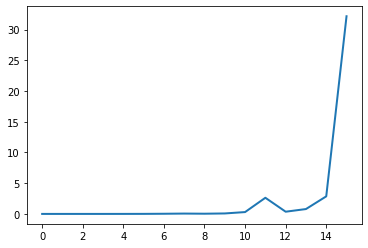

In [415]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(time, linewidth=2.0)

plt.show()

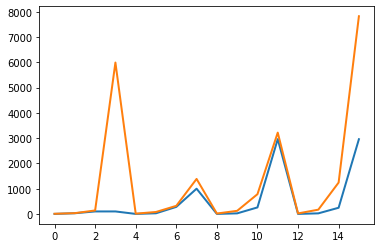

In [416]:
fig, ax = plt.subplots()

ax.plot(size, linewidth=2.0)
ax.plot(upper_bound, linewidth=2.0)

plt.show()